In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("data/final_data.csv")

In [3]:
X = data.drop(columns=["fare_amount", "key"])
y = data["fare_amount"]

In [4]:
def standardize_train_val(X_train, X_val, features_to_scale):
    """
    Standardize the training and validation sets separately to prevent data leakage.

    Parameters:
    - X_train: DataFrame, training features
    - X_val: DataFrame, validation features
    - features_to_scale: list, names of the features to be standardized

    Returns:
    - X_train_scaled: DataFrame, standardized training features
    - X_val_scaled: DataFrame, standardized validation features
    """
    scaler = StandardScaler()

    X_train.loc[:, features_to_scale] = scaler.fit_transform(X_train[features_to_scale])
    X_val.loc[:, features_to_scale] = scaler.transform(X_val[features_to_scale])
    
    return X_train, X_val

In [5]:
features_to_scale = [
    "distance_km", 
    "oil_price", 
    "passenger_count", 
    "feat1", 
    "feat2", 
    "feat3", 
    "feat4", 
    "feat5", 
    "feat6", 
    "feat7", 
    "feat8", 
    "feat9", 
    "feat10",
    "TMIN",
    "TMAX",
    "PRCP",
    "SNOW",
    "SNWD",
]

param_dist = {
    'n_estimators': [100, 120, 125, 135, 150],
    'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1],
    'max_depth': [5, 6, 7, 8, 9],
    'subsample': [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.65, 0.7, 0.75, 0.8, 0.9, 1.0],
    'gamma': [0.1, 0.15, 0.2, 0.25, 0.3],
    'min_child_weight': [9, 10, 11, 12, 13, 14, 15, 16, 17, 18], 
    'reg_alpha': [0, 0.05, 0.07, 0.1, 0.12, 0.15, 0.2 ],
    'reg_lambda': [1.0, 2.0, 3.0, 4.0, 5.0]
}

In [31]:
def cross_validate_random_search_xgboost(X, y, param_dist, features_to_scale, cv=10, n_iter=10, random_state=42):
    """
    Cross-validate a Random Search XGBoost model and calculate RMSE.

    Parameters:
    - X: DataFrame, features
    - y: Series, target variable
    - features_to_scale: list, names of the features to be standardized
    - cv: int, number of cross-validation folds
    - n_iter: int, number of iterations for Random Search
    - random_state: int, random seed for reproducibility

    Returns:
    - mean_rmse: float, mean RMSE across all folds
    - std_rmse: float, standard deviation of RMSE across all folds
    """
    skf = KFold(n_splits=cv, shuffle=True, random_state=random_state)
    rmse_scores = []
    param_sets = []

    # custom Random Search, because of KFold
    for i in range(n_iter):
        params = {k: np.random.choice(v) for k, v in param_dist.items()}
        param_sets.append(params)

    for params in param_sets:
        fold_rmse_scores = []

        for train_idx, test_idx in skf.split(X, y):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            X_train, X_test = standardize_train_val(X_train, X_test, features_to_scale)

            model = xgb.XGBRegressor(**params, random_state=random_state)
            model.fit(X_train, y_train)

            y_pred = model.predict(X_test)
            rmse = root_mean_squared_error(y_test, y_pred)
            fold_rmse_scores.append(rmse)

        mean_rmse = np.mean(fold_rmse_scores)
        rmse_scores.append(mean_rmse)

        print(f"Hyperparameters: {params}")
        print(f"Mean RMSE: {mean_rmse}")
        print("-" * 50)

    best_index = np.argmin(rmse_scores)
    best_params = param_sets[best_index]
    best_rmse = rmse_scores[best_index]

    return best_params, best_rmse

In [ ]:
best_params, best_rmse = cross_validate_random_search_xgboost(X, y, 
                    param_dist=param_dist, 
                    features_to_scale=features_to_scale, 
                    cv=10, n_iter=200, random_state=42)

print(f"Best Hyperparameters: {best_params}")
print(f"Best Cross-Validated RMSE: {best_rmse}")

#1 Best Hyperparameters: {'n_estimators': 100, 'learning_rate': 0.08, 'max_depth': 7, 'subsample': 0.9, 'colsample_bytree': 1.0, 'gamma': 0.1, 'min_child_weight': 15, 'reg_alpha': 0.0, 'reg_lambda': 5.0}
#1 Best Cross-Validated RMSE: 4.844881189242644

## NN

In [6]:
from tensorflow.keras import layers
import tensorflow as tf
from kerastuner import Objective
from kerastuner.tuners import RandomSearch, BayesianOptimization
from kerastuner.engine.hyperparameters import HyperParameters
import random

from sklearn.model_selection import train_test_split

tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
input_shape = X.shape[1]
input_shape

32

In [46]:
nn_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=input_shape, activation='relu', input_shape=(input_shape,), name="input_layer"),
    tf.keras.layers.Dense(units=128, activation='relu', name="hidden_layer1"),
    tf.keras.layers.Dense(units=128, activation='relu', name="hidden_layer2"),
    tf.keras.layers.Dense(units=64, activation='relu', name="hidden_layer3"),
    tf.keras.layers.Dense(units=64, activation='relu', name="hidden_layer4"),
    tf.keras.layers.Dense(units=32, activation='relu', name="hidden_layer5"),
    tf.keras.layers.Dense(units=64, activation='relu', name="hidden_layer6"),
    tf.keras.layers.Dense(units=32, activation='relu', name="hidden_layer7"),
    tf.keras.layers.Dense(units=32, activation='relu', name="hidden_layer8"),
    tf.keras.layers.Dense(units=16, activation='relu', name="hidden_layer9"),
    tf.keras.layers.Dense(1, activation=None, name="output_layer")
])

In [47]:
nn_model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [48]:
history = nn_model.fit(
    X_train, y_train,
    epochs = 50,
    shuffle = True,
)

Epoch 1/50
2205/2205 [==============================] - 3s 1ms/step - loss: 42.6713 - root_mean_squared_error: 6.5323
Epoch 2/50
2205/2205 [==============================] - 2s 1ms/step - loss: 32.9695 - root_mean_squared_error: 5.7419
Epoch 3/50
2205/2205 [==============================] - 2s 1ms/step - loss: 32.2011 - root_mean_squared_error: 5.6746
Epoch 4/50
2205/2205 [==============================] - 2s 1ms/step - loss: 31.7506 - root_mean_squared_error: 5.6348
Epoch 5/50
2205/2205 [==============================] - 2s 1ms/step - loss: 32.2533 - root_mean_squared_error: 5.6792
Epoch 6/50
2205/2205 [==============================] - 2s 1ms/step - loss: 30.7621 - root_mean_squared_error: 5.5464
Epoch 7/50
2205/2205 [==============================] - 2s 1ms/step - loss: 30.8570 - root_mean_squared_error: 5.5549
Epoch 8/50
2205/2205 [==============================] - 2s 1ms/step - loss: 30.4663 - root_mean_squared_error: 5.5196
Epoch 9/50
2205/2205 [==============================] - 

In [ ]:
nn_model.evaluate(X_test, y_test)

552/552 [==============================] - 1s 746us/step - loss: 26.8251 - root_mean_squared_error: 5.1793


[26.825057983398438, 5.179291248321533]

Text(0.5, 0, 'epochs')

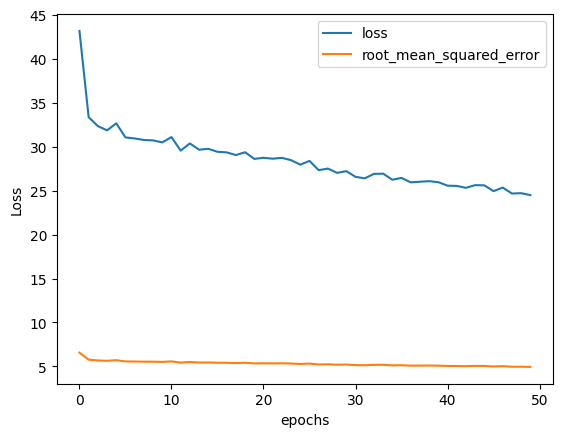

In [34]:
pd.DataFrame(history.history).plot()
plt.ylabel("Loss")
plt.xlabel("epochs")

In [63]:
def build_model(hp):
    print("\nBuilding model with the following hyperparameters:")
    
    model = tf.keras.Sequential()
    input_shape = X.shape[1]
    
    model.add(layers.Dense(input_shape, input_shape=(input_shape,), activation='relu', name="input_layer"))
    print(f"Added input layer with {input_shape} units and 'relu' activation.")
    
    num_layers = hp.Int('num_layers', 3, 10)
    print(f"Number of hidden layers: {num_layers}")
    
    for i in range(num_layers):
        units = hp.Choice(f'units_{i}', values=[8, 16, 32, 64, 128, 256, 512, 1024])
        activation = hp.Choice(f'activation_{i}', values=['relu', 'gelu', 'linear', 'leaky_relu'])
        model.add(layers.Dense(units=units, activation=activation))
        print(f"Added hidden layer {i+1} with {units} units and '{activation}' activation.")
    
    model.add(layers.Dense(1, activation=None, name="output_layer"))
    print("Added output layer with 1 unit and no activation.")
    
    learning_rate = hp.Choice('learning_rate', [1.5e-2, 1e-2, 1e-3, 1e-4])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )
    print(f"Model compiled with learning rate: {learning_rate}")
    
    print("Model building completed.\n")
    
    return model

In [ ]:
tuner = RandomSearch(
    hypermodel=build_model,
    objective=Objective("val_root_mean_squared_error", direction="min"),
    max_trials=50,
    executions_per_trial=3,
    project_name='tuning',
    seed=42
)

tuner.search(X_train, y_train, epochs=40, validation_data=(X_val, y_val))

best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print(best_hyperparameters.values)

In [64]:
def bayesian_optimization_neural_net(X, y, features_to_scale, n_iter=10, random_state=42):
    """
    Use Bayesian Optimization to find the best neural network architecture and hyperparameters.

    Parameters:
    - X: DataFrame, features
    - y: Series, target variable
    - features_to_scale: list, names of the features to be standardized
    - n_iter: int, number of iterations for Bayesian Optimization
    - random_state: int, random seed for reproducibility

    Returns:
    - best_model: tf.keras.Model, the best model found
    - best_hyperparameters: dict, best hyperparameters found
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    X_train, X_test = standardize_train_val(X_train, X_test, features_to_scale)

    tuner = BayesianOptimization(
        hypermodel=build_model,
        objective=Objective("val_root_mean_squared_error", direction="min"),
        max_trials=n_iter,
        executions_per_trial=2,
        project_name='neural_net_tuning_bayesian',
        seed=random_state
    )

    tuner.search(X_train, y_train, epochs=40, validation_split=0.2, verbose=1, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])

    best_model = tuner.get_best_models(num_models=1)[0]
    best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

    return best_model, best_hyperparameters

In [66]:
best_model, best_hyperparameters = bayesian_optimization_neural_net(X, y, 
                            features_to_scale=features_to_scale, 
                            n_iter=100, 
                            random_state=42)
print("Best Hyperparameters:", best_hyperparameters)
print("Best RMSE:", best_model)

Trial 100 Complete [00h 03m 40s]
val_root_mean_squared_error: 5.093004465103149

Best val_root_mean_squared_error So Far: 4.919163227081299
Total elapsed time: 05h 11m 28s

Building model with the following hyperparameters:
Added input layer with 32 units and 'relu' activation.
Number of hidden layers: 6
Added hidden layer 1 with 32 units and 'linear' activation.
Added hidden layer 2 with 8 units and 'relu' activation.
Added hidden layer 3 with 64 units and 'gelu' activation.
Added hidden layer 4 with 128 units and 'leaky_relu' activation.
Added hidden layer 5 with 1024 units and 'relu' activation.
Added hidden layer 6 with 512 units and 'relu' activation.
Added output layer with 1 unit and no activation.
Model compiled with learning rate: 0.001
Model building completed.

Best Hyperparameters: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x0000020CF38B4640>
Best RMSE: <keras.src.engine.sequential.Sequential object at 0x0000020D793B68C0>


In [58]:
print("Best Hyperparameters:")
for param, value in best_hyperparameters.values.items():
    print(f"{param}: {value}")

test_loss, test_rmse = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Best RMSE on Test Set: {test_rmse:.4f}")

Best Hyperparameters:
num_layers: 12
units_0: 8
activation_0: linear
units_1: 16
activation_1: gelu
units_2: 64
activation_2: leaky_relu
units_3: 64
activation_3: gelu
units_4: 64
activation_4: relu
units_5: 8
activation_5: linear
learning_rate: 0.001
units_6: 1024
activation_6: gelu
units_7: 8
activation_7: gelu
units_8: 512
activation_8: gelu
units_9: 32
activation_9: leaky_relu
units_10: 8
activation_10: relu
units_11: 8
activation_11: relu
Best RMSE on Test Set: 14.7780
